# Analyze Sample Movies Separately

**Author**: Prisca Dotti  
**Last Modified**: 04.05.2024

This script contains the code to manually inspect individual videos. This means opening them with Napari and checking for issues in the predictions.

### TODO  
(As of 31.10.2023)

- Check if removing small events in the network's output actually removes some correct events.
- Check how often sparks and puffs are confused.
- The `get_puff_signal` function still needs to be improved (+ still need function for waves signal).

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import napari

from scipy.ndimage import find_objects, center_of_mass, gaussian_filter
from sklearn.metrics.pairwise import euclidean_distances
from skimage import morphology

import torch
from torch import nn
from torch.utils.data import DataLoader

from data.data_processing_tools import (
    process_raw_predictions,
    preds_dict_to_mask,
    get_otsu_argmax_segmentation,
    get_separated_events,
    remove_small_events,
    get_cell_mask,
    detect_spark_peaks,
    detect_puff_centers,
    compute_tyx_self_ratio,
    remove_background,
)
from utils.training_inference_tools import do_inference
from utils.training_script_utils import init_dataset, init_model
from utils.visualization_tools import (
    get_discrete_cmap,
    get_labels_cmap,
    get_spark_signal,
    get_spark_2d_signal,
    get_annotations_contour,
    get_instances_contour,
    create_signal_mask,
    plot_event_t_profile_2d_surface,
)
from config import config, TrainingConfig

# Configure Napari cmap
cmap = get_discrete_cmap(name="gray", lut=16)
labels_cmap = get_labels_cmap()

## Load movies and get predictions

Old version of script used stored predictions, but actually it is so fast that it does not make sense to keep them on disk (getting raw predictions of all test samples take ~10 minutes).


In [3]:
############################ Get dataset parameters ############################

# Get excel file with all the dataset metadata
metadata_path = (
    r"C:\Users\dotti\OneDrive - Universitaet Bern\sparks_code_local\movies_summary.xlsx"
    # r"C:\Users\prisc\OneDrive - Universitaet Bern\sparks_code_local\movies_summary.xlsx"
)
# Load the column "Movie ID" as string to avoid losing leading zeros
metadata_df = pd.read_excel(metadata_path, dtype={"Movie ID": str})
# Remove columns with "In Dataset" == "no"
metadata_df = metadata_df[metadata_df["In Dataset"] == "yes"]

# Get dataset_ids as values in the "Movie ID" column
dataset_ids = list(metadata_df["Movie ID"].values)

# Get values in "Movie ID" column with column "Train/Test" == "test"
test_ids = list(metadata_df[metadata_df["Train/Test"] == "test"]["Movie ID"].values)

# Get FPS for each sample
fps_dict = dict(metadata_df[["Movie ID", "FPS"]].values)

sample_ids = test_ids
# sample_ids = ["01", "21"]

In [4]:
metadata_df.head()

,Movie ID,In Dataset,Original Name,Mouse Model,Cell Type,Train/Test,Num Frames,Original Num Frames,Num Sparks,Num Puffs,Num Waves,Waves Remarks,Remarks,Acquisition Date,Cell Identifier,Pharmacology,FPS
0,01,yes,130906 C ET-1,WT Bl.6,atria,train,500,500,23,6,0,NaN,"1 spark manually added (P, frame 80), manual corr",2013-09-06,C,ET-1,138.8
1,02,yes,130918 C ET-1,WT Bl.6,atria,train,500,500,9,3,2,large,manual corr,2013-09-18,C,ET-1,147.5
2,03,yes,130921 E ET-1,WT Bl.6,atria,train,500,500,24,14,0,NaN,manual corr,2013-09-21,E,ET-1,147.5
3,04,yes,130926 C ET-1,WT Bl.6,atria,train,500,500,26,3,0,NaN,manual corr,2013-09-26,C,ET-1,147.5
4,05,yes,131104 D ET-1,WT Bl.6,atria,test,500,500,71,26,0,NaN,manual corr,2013-11-04,D,ET-1,139.7


In [5]:
training_name = "final_model"
config_filename = "config_final_model.ini"
load_epoch = 100000

# Initialize general parameters
params = TrainingConfig(
    training_config_file=os.path.join("config_files", config_filename)
)

params.run_name = training_name
params.set_device(device="auto")
model_filename = f"network_{load_epoch:06d}.pth"

# Output directory
out_dir = os.path.join(
    config.basedir, "evaluation", "manual_analysis_movies_script", training_name
)
os.makedirs(out_dir, exist_ok=True)

[15:40:08] [  INFO  ] [   config   ] <316 > -- Loading C:\Users\dotti\Code\sparks_project\config_files\config_final_model.ini


### Create dataset

In [6]:
# Create dataset
dataset = init_dataset(
    params=params,
    sample_ids=sample_ids,
    apply_data_augmentation=False,
    print_dataset_info=True,
    load_instances=True,
)

# Create a dataloader
dataset_loader = DataLoader(
    dataset,
    batch_size=params.inference_batch_size,
    shuffle=False,
    num_workers=params.num_workers,
    pin_memory=params.pin_memory,
)

# xs = dataset.get_movies()
# ys = dataset.get_labels()
# ys_instances = dataset.get_instances()

[15:40:53] [  INFO  ] [utils.training_script_utils] <149 > -- Samples in dataset: 158


### Configure DL model

In [7]:
# Configure model architecture
network = init_model(params=params)

# Move the model to the GPU if available
if params.device.type != "cpu":
    network = nn.DataParallel(network).to(params.device, non_blocking=True)
    # cudnn.benchmark = True

# Load model weights
models_relative_path = os.path.join(
    "models", "saved_models", params.run_name, model_filename
)
model_dir = os.path.realpath(os.path.join(config.basedir, models_relative_path))

In [8]:
# Load the model state dictionary
print(f"Loading trained model '{params.run_name}' at epoch {load_epoch}...")
try:
    network.load_state_dict(torch.load(model_dir, map_location=params.device))
except RuntimeError as e:
    if "module" in str(e):
        # The error message contains "module," so handle the DataParallel loading
        print(
            "Failed to load the model, as it was trained with DataParallel. Wrapping it in DataParallel and retrying..."
        )
        # Get current device of the object (model)
        temp_device = next(iter(network.parameters())).device

        network = nn.DataParallel(network)
        network.load_state_dict(torch.load(model_dir, map_location=params.device))

        print("Network should be on CPU, removing DataParallel wrapper...")
        network = network.module.to(temp_device)
    else:
        # Handle other exceptions or re-raise the exception if it's unrelated
        raise

Loading trained model 'final_model' at epoch 100000...


### Get predictions

In [9]:
# get U-Net's raw predictions
network.eval()
raw_preds_inference = do_inference(
    network=network,
    params=params,
    dataloader=dataset_loader,
    device=params.device,
    compute_loss=False,
    inference_types=[params.inference],
)

# Remove middle dictionary from raw_preds
raw_preds = {idx: pred[params.inference] for idx, pred in raw_preds_inference.items()}

In [10]:
final_segmentation_dict = {}
final_instances_dict = {}
sparks_coords_dict = {}

for i in range(len(sample_ids)):
    # transform raw predictions into a dictionary
    raw_preds_dict = {
        event_type: raw_preds[i][event_label]
        for event_type, event_label in config.classes_dict.items()
        if event_type in config.event_types
    }

    movie_instances, movie_segmentation, sparks_coords = process_raw_predictions(
        raw_preds_dict=raw_preds_dict,
        input_movie=dataset.get_movies()[i],
        training_mode=False,
    )

    final_segmentation_dict[sample_ids[i]] = movie_segmentation
    final_instances_dict[sample_ids[i]] = movie_instances
    sparks_coords_dict[sample_ids[i]] = sparks_coords

## Visualise preds in a sample movie

In [11]:
sample_id = 1
movie_id = sample_ids[sample_id]

#### Visualize raw and segmented predictions

In [12]:
viewer = napari.Viewer()

viewer.add_image(
    dataset.get_movies()[sample_id], name="movie", colormap=("colors", cmap)
)

viewer.add_image(
    raw_preds[sample_id][1:],
    name=[
        "predicted sparks",
        "predicted waves",
        "predicted puffs",
    ],
    colormap=["green", "bop purple", "red"],
    channel_axis=0,
    blending="additive",
)

# get contours of annotated mask, for visualization
y_contours = get_annotations_contour(
    annotations=dataset.get_labels()[sample_id], contour_val=2
)
viewer.add_labels(
    y_contours, name="annotated segmentation", opacity=0.8, color=labels_cmap
)

# visualize detected events
pred_segmentation = preds_dict_to_mask(final_segmentation_dict[movie_id])
viewer.add_labels(
    pred_segmentation, name="segmented predictions", opacity=0.5, color=labels_cmap
)

[15:48:36] [WARNING ] [   vispy    ] <234 > -- DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=96


<Labels layer 'segmented predictions' at 0x267a4a01030>

#### Visualize detected event instances

In [14]:
annotations_border = get_instances_contour(
    dataset.get_instances()[sample_id], contour_val=2
)

In [18]:
pred_instances_dict = final_instances_dict[movie_id]

viewer2 = napari.Viewer()
viewer2.add_image(
    dataset.get_movies()[sample_id], name="movie", colormap=("colors", cmap)
)

for class_name, class_events in pred_instances_dict.items():
    viewer2.add_labels(class_events, name=class_name, opacity=0.5)

viewer2.add_labels(annotations_border, name="annotated events border", opacity=0.8)

[15:54:08] [WARNING ] [   vispy    ] <234 > -- DirectWrite: CreateFontFaceFromHDC() failed (Indicates an error in an input file such as a font file.) for QFontDef(Family="", pointsize=12, pixelsize=16, styleHint=5, weight=50, stretch=100, hintingPreference=0) LOGFONT("MS Sans Serif", lfWidth=0, lfHeight=-16) dpi=96


<Labels layer 'annotated events border' at 0x2679712b5e0>

#### Visualize annotated and predicted spark peaks

In [19]:
# Visualize sparks and their peaks
sparks_y_segmentation = (
    dataset.get_labels()[sample_id] == config.classes_dict["sparks"]
).astype(np.uint8)
sparks_y_segmentation_contour = get_annotations_contour(
    annotations=sparks_y_segmentation, contour_val=2
)
sparks_y_loc = dataset.spark_peaks[sample_id]

sparks_pred_segmentation = final_segmentation_dict[movie_id]["sparks"]
sparks_pred_loc = sparks_coords_dict[movie_id]["sparks"]

In [20]:
custom_cmap = {
    0: (0, 0, 0, 0),  # no color
    1: (0, 0, 0, 1),  # black
}

In [21]:
viewer3 = napari.Viewer()
viewer3.add_image(
    dataset.get_movies()[sample_id], name="movie", colormap=("colors", cmap)
)

viewer3.add_labels(
    sparks_y_segmentation_contour,
    name="annotated sparks",
    opacity=0.5,
    color=custom_cmap,
)

viewer3.add_labels(
    sparks_pred_segmentation,
    name="predicted binary sparks",
    opacity=0.5,
    color=custom_cmap,
)

viewer3.add_points(
    sparks_y_loc,
    name="annotated spark peaks",
    size=5,
    symbol="diamond",
    ndim=config.ndims,
    out_of_slice_display=True,
    edge_color="blue",
    opacity=0.8,
)

viewer3.add_points(
    sparks_pred_loc,
    name="predictes spark peaks",
    size=5,
    symbol="ring",
    ndim=config.ndims,
    out_of_slice_display=True,
    edge_color="red",
    opacity=0.8,
)

<Points layer 'predictes spark peaks' at 0x267ce31d570>

## Visualise interesting selected events

E.g., signal in time and 3D profile of FP sparks etc.

- If considering sparks: can use peak of event as a reference for the plots
- Otherwise, compute averaged signal in time

In [67]:
# Plot parameters
plt.rcParams.update({"font.size": 12})  # Set a common font size for all plot elements
figsize = (10, 4.5)
width_ratios = [4, 6]
height_ratios = [1, 25, 1]
linewidth = 0.7

### Ca2+ Sparks: plot predicted events

Analyzing Sample 45
Number of detected spark peaks: 14


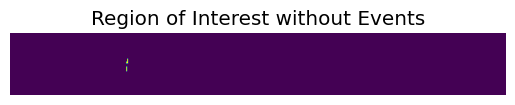

In [86]:
# Select samples to analyze
spark_sample_id = 8
spark_movie_id = sample_ids[spark_sample_id]

print(f"Analyzing Sample {spark_movie_id}")
idx = dataset.sample_ids.index(spark_movie_id)
original_movie = dataset.get_movies()[idx]
labels_mask = final_segmentation_dict[spark_movie_id]["sparks"]
sparks_mask = final_instances_dict[spark_movie_id]["sparks"]
labeled_events_mask = dataset.get_labels()[spark_sample_id]

# define smooth input movie used for plotting
smooth_movie = gaussian_filter(original_movie, sigma=1)

# get all spark peaks
spark_coords = detect_spark_peaks(
    movie=original_movie,
    instances_mask=sparks_mask,
    sigma=2,
    max_filter_size=10,
    return_mask=False,
)

print(f"Number of detected spark peaks: {len(spark_coords)}")
# Compute ROI without events
cell_mask = get_cell_mask(original_movie)
no_events_roi = ~np.any(labeled_events_mask, axis=0)
no_events_roi = no_events_roi & cell_mask
no_events_roi = morphology.binary_erosion(no_events_roi, morphology.disk(10))

plt.imshow(no_events_roi)
plt.axis("off")
plt.title("Region of Interest without Events")
plt.show()
# Compute the self-ratio for the movie
sr_movie = compute_tyx_self_ratio(original_movie, no_events_roi)

# Remove background from the self-ratio movie
no_bg_sr_movie = remove_background(sr_movie, mode="offline")

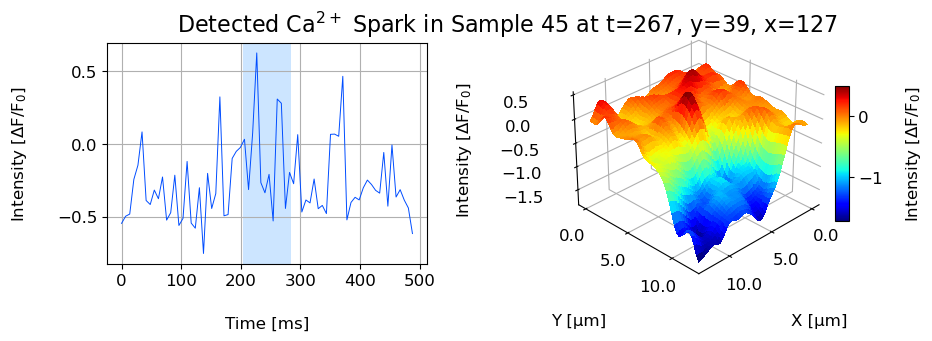

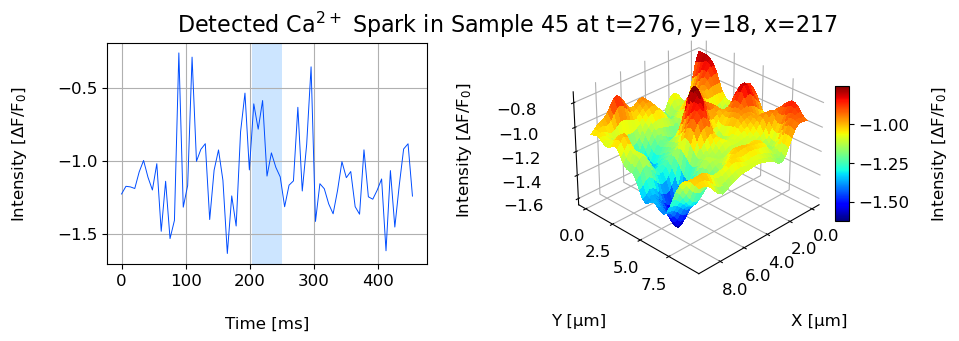

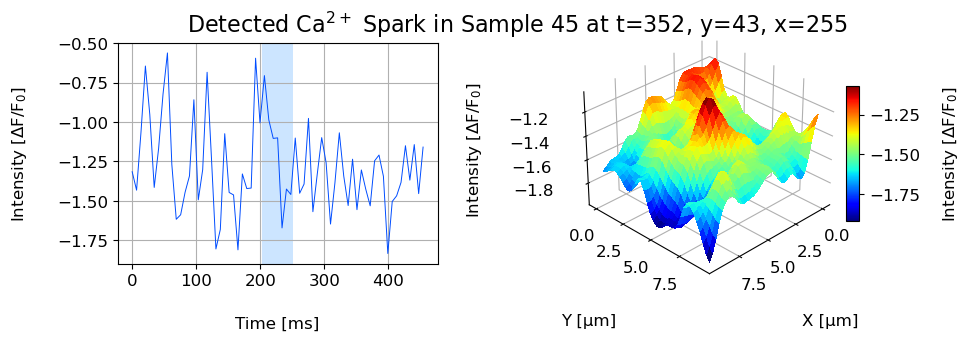

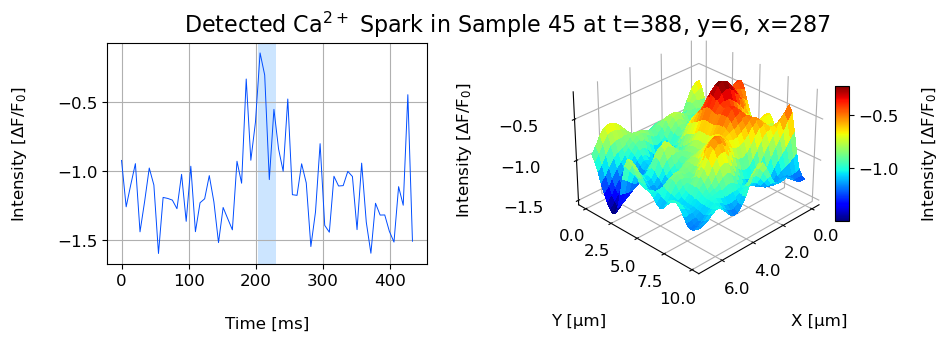

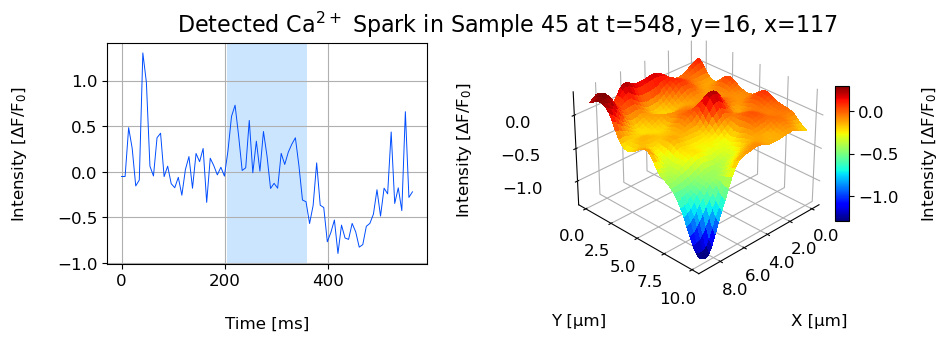

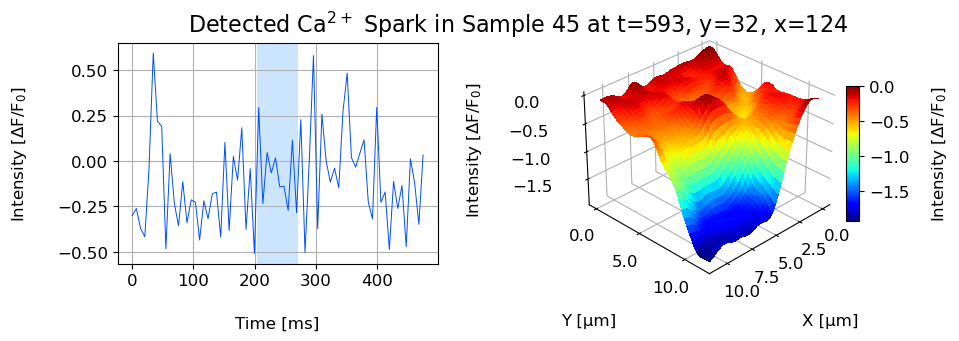

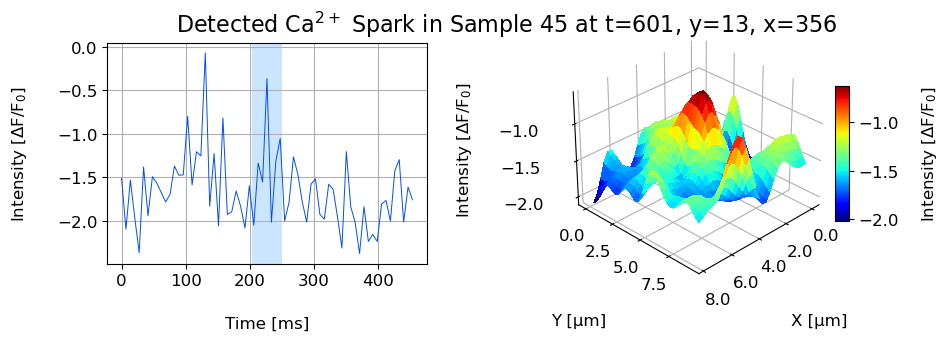

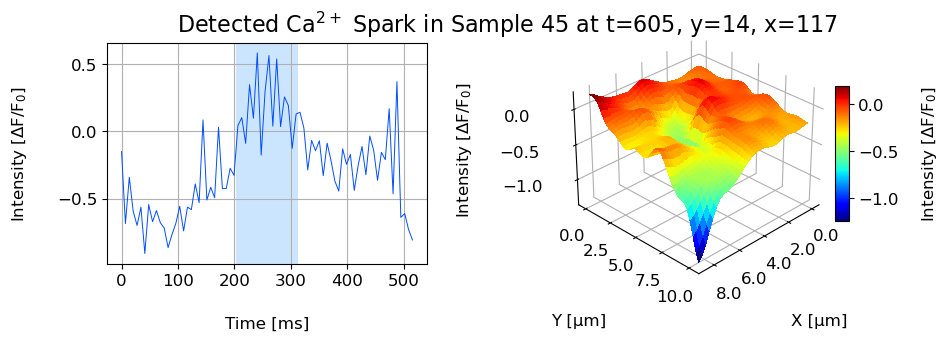

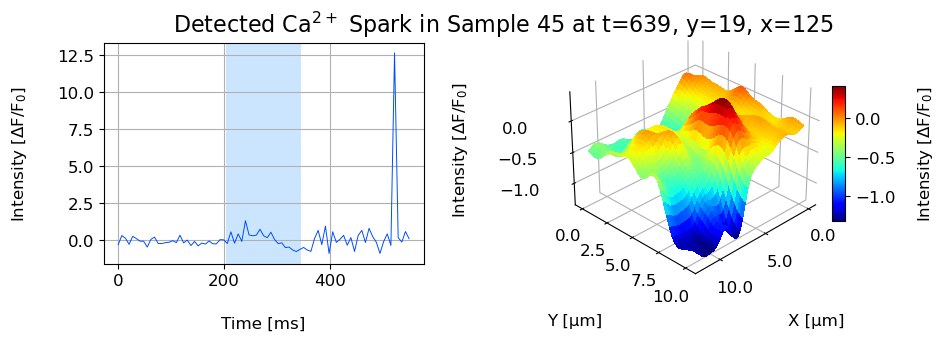

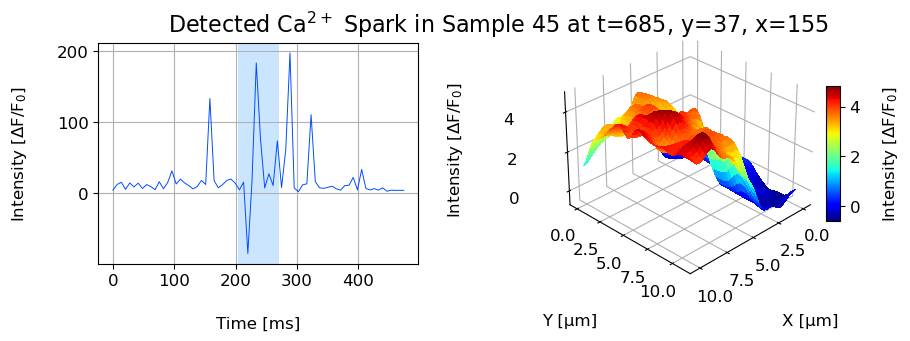

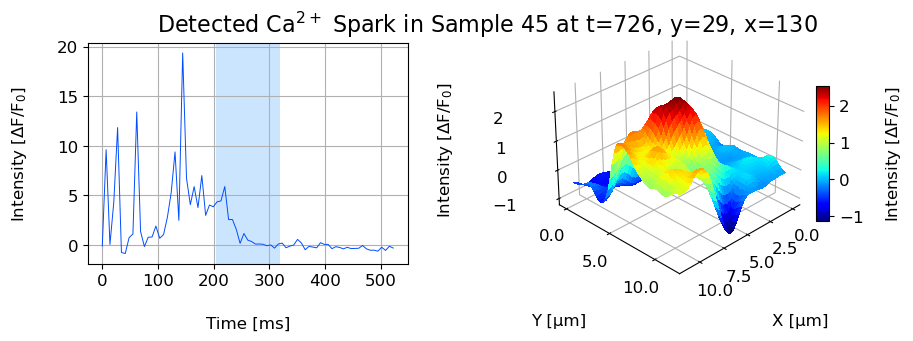

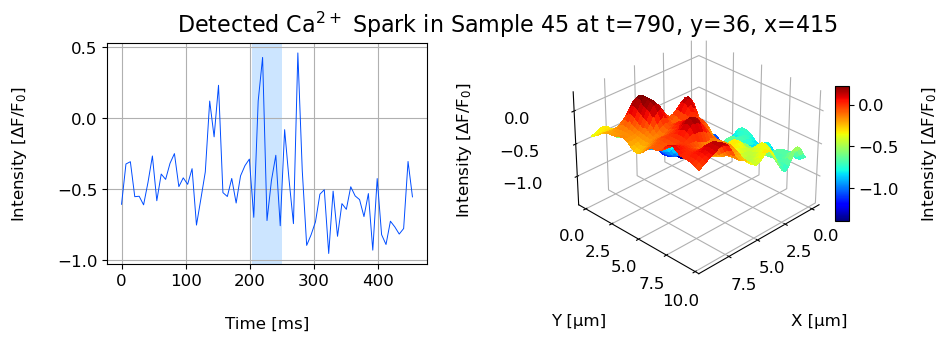

In [87]:
# signal parameters
spark_radius = 3
spark_t_context_duration = 30
spark_spatial_context = 15  # consider extended ROI

num_plot_sparks = min(12, len(spark_coords))  # plot at most
for spark_event_id in range(num_plot_sparks):
    t, y, x = spark_coords[spark_event_id]
    # print(f"Plotting Ca2+ Spark at t={t}, y={y}, x={x}")

    plot_event_t_profile_2d_surface(
        sample_id=spark_movie_id,
        # movie=original_movie,
        movie=no_bg_sr_movie,
        events_mask=sparks_mask,
        event_coord=(t, y, x),
        event_type="spark",
        fps=fps_dict[spark_movie_id],
        radius=spark_radius,
        t_context_duration=spark_t_context_duration,
        spatial_context=spark_spatial_context,
        figsize=figsize,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        linewidth=linewidth,
        elevation=30,
        azimuth=45,
        super_title="Detected Ca$^{2+}$ Spark in Sample "
        + str(spark_movie_id)
        + f" at t={t}, y={y}, x={x}",
    )

### Ca2+ Puffs: plot predicted events

Analyzing Sample 34
Number of detected puff centers: 21


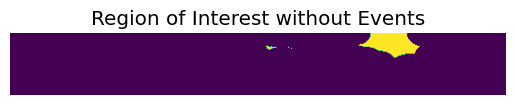

In [112]:
# Select samples to analyze
puff_sample_id = 6
puff_movie_id = sample_ids[puff_sample_id]

print(f"Analyzing Sample {puff_movie_id}")
idx = dataset.sample_ids.index(puff_movie_id)
original_movie = dataset.get_movies()[idx]
labels_mask = final_segmentation_dict[puff_movie_id]["puffs"]
puffs_mask = final_instances_dict[puff_movie_id]["puffs"]
labeled_events_mask = dataset.get_labels()[puff_sample_id]

# define smooth input movie used for plotting
smooth_movie = gaussian_filter(original_movie, sigma=1)

# get all spark peaks
puff_coords = detect_puff_centers(
    movie=original_movie,
    instances_mask=puffs_mask,
    sigma=2,
    max_filter_size=10,
    return_mask=False,
)
print(f"Number of detected puff centers: {len(puff_coords)}")

# Compute ROI without events
cell_mask = get_cell_mask(original_movie)
no_events_roi = ~np.any(labeled_events_mask, axis=0)
no_events_roi = no_events_roi & cell_mask
no_events_roi = morphology.binary_erosion(no_events_roi, morphology.disk(10))

plt.imshow(no_events_roi)
plt.axis("off")
plt.title("Region of Interest without Events")
plt.show()
# Compute the self-ratio for the movie
sr_movie = compute_tyx_self_ratio(original_movie, no_events_roi)

# Remove background from the self-ratio movie
no_bg_sr_movie = remove_background(sr_movie, mode="offline")

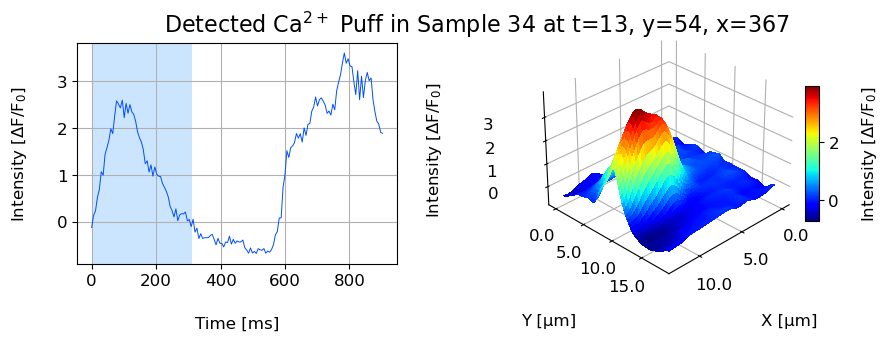

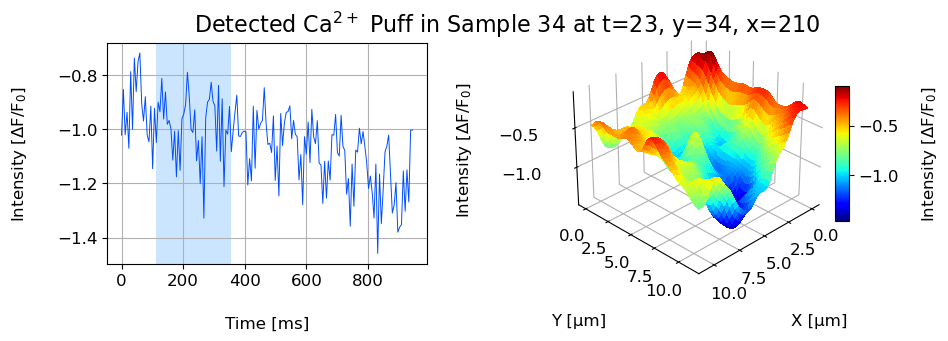

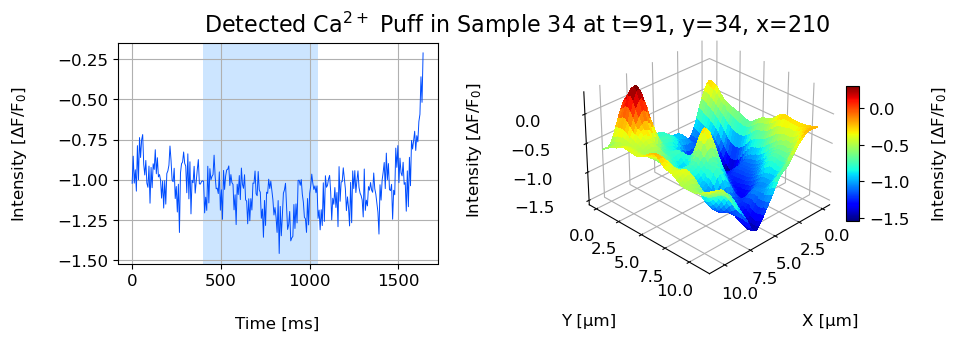

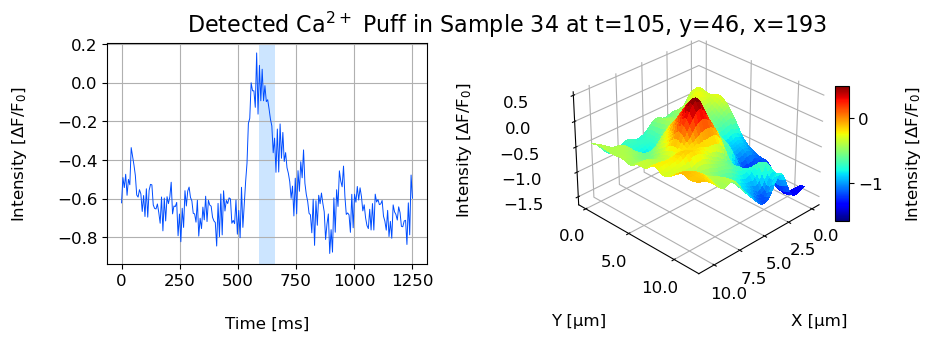

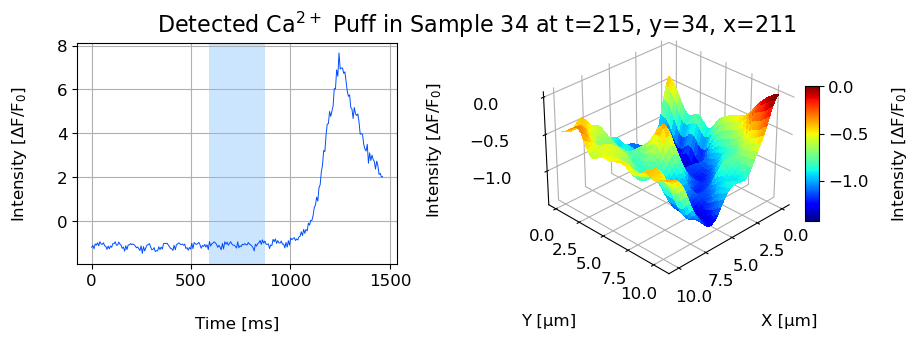

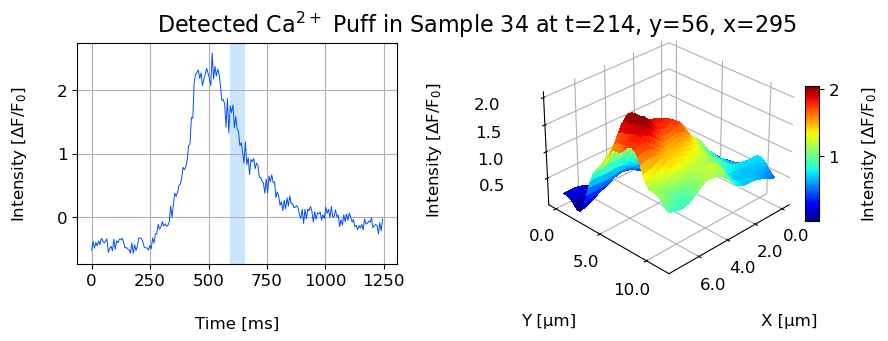

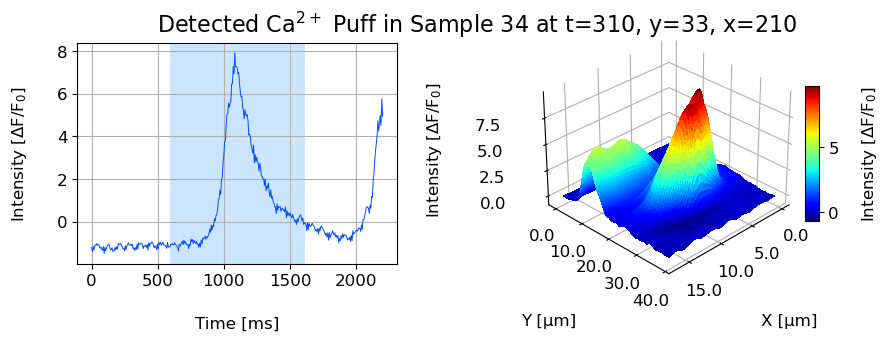

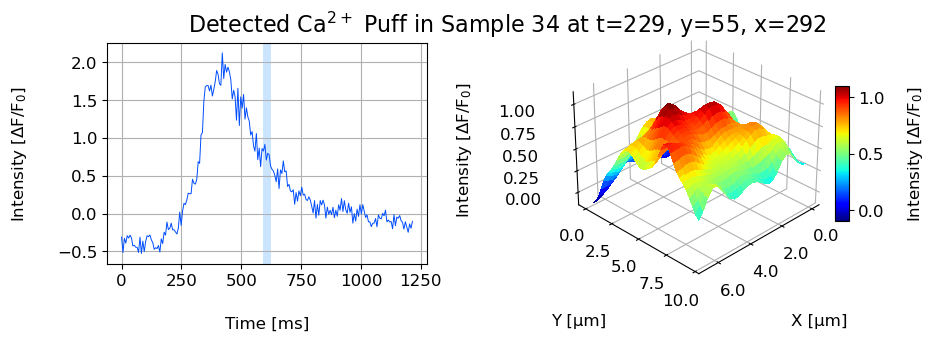

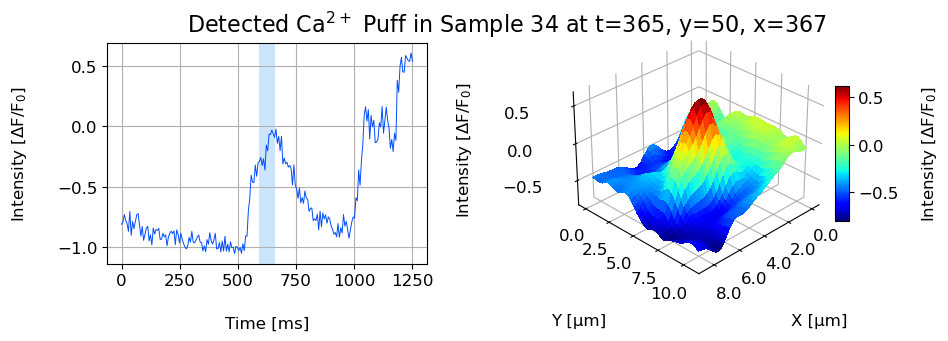

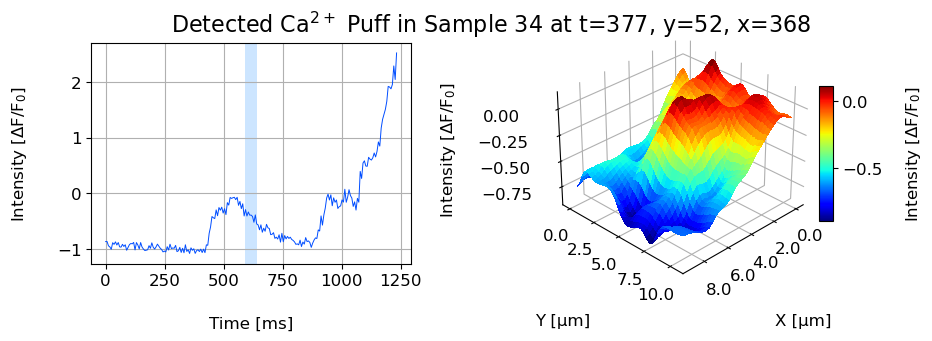

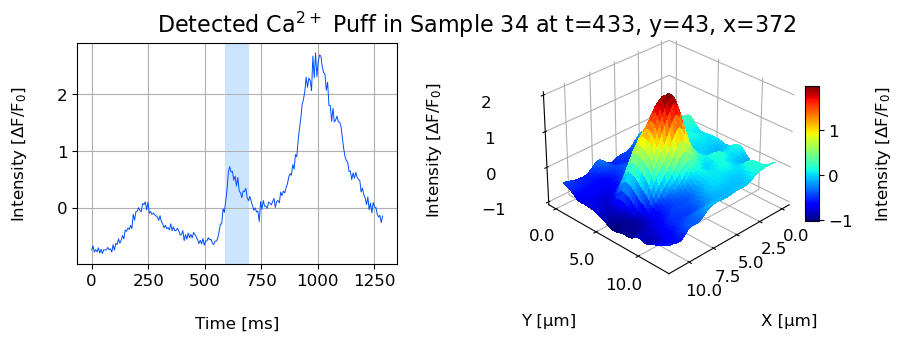

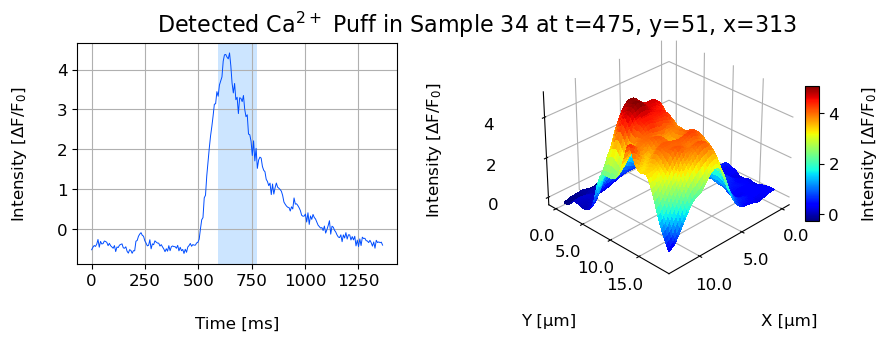

In [113]:
# signal parameters
puff_radius = 10
puff_t_context_duration = 100
puff_spatial_context = 15  # consider extended ROI

num_plot_puffs = min(12, len(puff_coords))  # plot at most
for puff_event_id in range(num_plot_puffs):
    t, y, x = puff_coords[puff_event_id]
    # print(f"Plotting Ca2+ Puff at t={t}, y={y}, x={x}")

    plot_event_t_profile_2d_surface(
        sample_id=puff_movie_id,
        # movie=original_movie,
        movie=no_bg_sr_movie,
        events_mask=puffs_mask,
        event_coord=(t, y, x),
        event_type="puff",
        fps=fps_dict[puff_movie_id],
        radius=puff_radius,
        t_context_duration=puff_t_context_duration,
        spatial_context=puff_spatial_context,
        figsize=figsize,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
        linewidth=linewidth,
        elevation=30,
        azimuth=45,
        super_title="Detected Ca$^{2+}$ Puff in Sample "
        + str(puff_movie_id)
        + f" at t={t}, y={y}, x={x}",
    )

## Visualize removed small events

In [42]:
sample_ids

['05', '10', '15', '20', '25', '32', '34', '40', '45']

In [67]:
sample_id = 8
movie_id = sample_ids[sample_id]

In [68]:
raw_pred = raw_preds[sample_id]  # (4, 500, 64, 512)
sample_movie = xs[sample_id]  # (500, 64, 512)

In [69]:
# Get dict of predicted events
raw_pred_dict = {
    event_type: raw_pred[event_label]
    for event_type, event_label in config.classes_dict.items()
    if event_type != "ignore"
}

In [70]:
# Get argmax segmentation using Otsu threshold on summed predictions
pred_segmentation_dict, _ = get_otsu_argmax_segmentation(
    preds=raw_pred_dict, return_classes=True, debug=False
)

In [71]:
# Separate events in predictions
pred_instances_dict, coords_events = get_separated_events(
    argmax_preds=pred_segmentation_dict,
    movie=sample_movie,
    training_mode=False,
)

In [72]:
# Remove small events and merge events that belong together
# Labelling removed events with a new id (9999)
new_id = 9999
clean_pred_instances_dict = remove_small_events(
    instances_dict=pred_instances_dict, new_id=new_id
)

In [73]:
removed_instances_dict = {}
for event_type in pred_instances_dict.keys():
    original_instances = pred_instances_dict[event_type]
    clean_instances = clean_pred_instances_dict[event_type]

    mask = np.where(clean_instances == new_id, original_instances, 0)
    removed_instances_dict[event_type] = mask

In [74]:
viewer = napari.Viewer()

viewer.add_image(sample_movie, name="movie", colormap=("colors", cmap), opacity=0.5)

# Visualize predicted events' segmentation
pred_segmentation = preds_dict_to_mask(preds_dict=pred_segmentation_dict)
viewer.add_labels(
    pred_segmentation,
    name="segmented predictions",
    opacity=0.25,
    color=labels_cmap,
    blending="additive",
)

# Visualize annotated events' contours
y_contours = get_annotations_contour(annotations=ys[sample_id], contour_val=2)
viewer.add_labels(
    y_contours,
    name="annotated segmentation",
    opacity=0.25,
    color=labels_cmap,
    blending="additive",
)
# Visualize removed event's in a different color
custom_cmap = {
    0: (0, 0, 0, 0),  # no color
    1: (0, 0, 1, 1),  # blue
    2: (0, 0, 1, 1),  # blue
    3: (0, 0, 1, 1),  # blue
}
removed_instances_mask = preds_dict_to_mask(preds_dict=removed_instances_dict)
viewer.add_labels(
    removed_instances_mask,
    name="removed instances",
    opacity=1.0,
    color=custom_cmap,
    blending="additive",
)

# # Visualize removed instances
# for event_type, event_instances in removed_instances_dict.items():
#     if event_instances.max() > 0:
#         viewer.add_labels(event_instances, name=event_type, blending="additive")

<Labels layer 'removed instances' at 0x21234e7d480>

**Minimal Dimensions to Remove Small Events in U-Net Detections**

The following parameters control the minimal dimensions to remove small events in UNet detections:

| Event Type | Duration | Height | Width |
|------------|----------|--------|-------|
| Sparks     | 2 frames | 3 pixels | 3 pixels |
| Waves      | No minimum | No minimum | 15 pixels |
| Puffs      | 5 frames | No minimum | No minimum |

**Maximal Gap Between Two Predicted Puffs or Waves That Belong Together**

The following parameters determine the maximal gap between two predicted puffs or waves that belong together (measured in frames):

| Event Type | Max Gap (in frames) |
|------------|----------------------|
| Sparks     | No maximum           |
| Waves      | Up to 2 frames       |
| Puffs      | Up to 2 frames       |

**Comments about removed events**

| Movie ID | Comments |
|------------|----------------------|
| *05*     | Some events are removed but they are very small, removed events mostly make sense |
| *10*     | Same as 05 |
| *15*     | Same as 05 |
| *20*     | Same as 05 |
| *25*     | Ok |
| *32*     | Same as 05 |
| *34*     | Some waves on the right border of cell are removed! Maybe the params for removing waves should be more restrictive |
| *40*     | Same as 05 |
| *45*     | Ok |


**General remarks** (for future model improvement):
- I should annotated as "ignore" all events that overlap with the first and last ~6 frames of the movies
- Movie 05 should be split where there is a jump in the recording
- Movie 45 does not contain annotations for sparks and puffs, maybe I should remove detected sparks and puffs from it (they count as false positive)
